In [1]:
# # !!! only uncomment and run when using colab !!!
# import os
# ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
# os.chdir("/content/CPlantBox/")
# ! cmake .
# ! make
# os.chdir("/content/CPlantBox/tutorial/jupyter/workshop_11_2_2022/")

# Workshop 11.2.2022 - (3/4)

## Simulation of xylem water movement 

For calculation of xylem water movement it is necessary to describe the matric potential around the root segments. In the following example we consider a static root system and a static soil. 

The soil is either coupled 

1. per a soil matric potential around each root segment, or 

2. the soil matric potentials are given in a soil domain, and each segment is located within a soil cell. 

The second approach is necessary if we extend the method to a dynamic soil, where the soil water potentials are calculated by an external PDE solver. 

To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). Note that the model ist static (as most models are). 

In the following we will show how to compute water xylem flux, standard uptake fraction (SUF), root sytem conductance (Krs), and show how the mapping between root segments and soil cells is realized. 

**Reference**

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

In [3]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src")
import plantbox as pb
import visualisation.vtk_plot as vp
from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt

## 1. Soil matric potentials per root segment

We start with a minimal example with constant conductivities (based on *example6b_xylemflux.py*), where we give the total potential per segment

In [16]:
""" root system """
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)
# _ = vp.plot_roots(pb.SegmentAnalyser(rs.mappedSegments()), "subType") 

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -300  # top soil pressure [cm]
p0 = -500  # dirichlet bc at root col'lar [cm]
trans = -1.2  # neuman bc at root collar [cm3/day]

""" prepare soil matric potentials per segment"""
segs = rs.segments # MappedRootSystem has access to segments and nodes 
nodes = rs.nodes
p_s = np.zeros((len(segs),)) # soil total potentials around each root segment
for i, s in enumerate(segs):
    p_s[i] = p_top - 0.5 * (nodes[s.x].z + nodes[s.y].z)  # constant total potential (hydraulic equilibrium)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
#
# In the following 'cells = False' means total soil potentials 'p_s' is given for each segment
#

# rx = r.solve_neumann(simtime, trans, p_s, cells = False) # use Neumann bc 
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) # use Dirichlet bc
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000) # use Neumann, switch to Dirichlet if below wilting_point

fluxes = r.segFluxes(simtime, rx, p_s, cells = False)  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
ana.addData("rx", rx) # add simulation result
# _ = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)")  
surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)  # we convert to [cm3/(cm2 day)]
fluxes = np.divide(fluxes, surfs) # add simulation result
ana.addData("fluxes", fluxes[1:]) # add simulation result 
_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 

Seed::initialize: RootSystem 
Kr is constant per type, type 0 = 0 1 day-1 
Kx is constant per subtype, subtype 0 = 1 cm3 day-1 
Kr is age dependent per root type
Kx is age dependent per root type
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 3, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
MappedRootSystem::initialize 
Transpiration -1.1999999999999695 cm3/day


Choices to define conductivities are
* constant
* constant per root subType
* root segment age dependent, given per look up table (values are linearly interpolated between the sample points)
* root segment age dependent, given per look up table per subType
* conductivity values per segment

Age dependent concuctivities are given in the following way (some examples are in CPlantBox/src/python_modules/root_conductivities.py):

0.357
0.0040709677419354835

SubType 0 for negative age: kx = 1, kr = 0
SubType 0 for old root age: kx = 1, kr = 0
SubType 1 for negative age: kx = 0.0674, kr = 0
SubType 1 for old root age: kx = 0.357, kr = 0.000517
SubType 2 for negative age: kx = 0.000407, kr = 0
SubType 2 for old root age: kx = 0.0136, kr = 0.00158
SubType 3 for negative age: kx = 0.000407, kr = 0
SubType 3 for old root age: kx = 0.0136, kr = 0.00158
SubType 4 for negative age: kx = 0.000407, kr = 0
SubType 4 for old root age: kx = 0.0136, kr = 0.00158



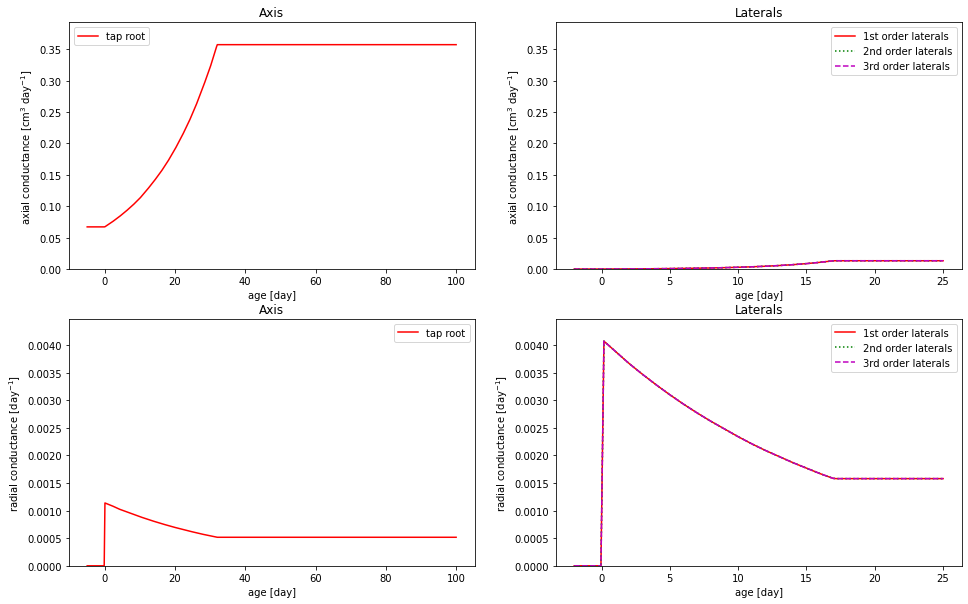

kr, tap root, age 0 0.00114
kr, laterals, age 0 0.00411
kx, tap root, age 0 0.0674
kx, laterals, age 0 0.000407


In [8]:
# tabular values for radial conductivity [1/day] for age and type dependent case (age, value) 
kr_collar = np.array([[0., 0.]]) # no uptake of the artificial shoot
kr1 = np.array([[-1e4, 0.], [-1.e-9, 0.], [0, 1.14e-03], [2, 1.09e-03], [4, 1.03e-03], [6, 9.83e-04], [8, 9.35e-04], [10, 8.90e-04], [12, 8.47e-04], [14, 8.06e-04], [16, 7.67e-04], [18, 7.30e-04], [20, 6.95e-04], [22, 6.62e-04], [24, 6.30e-04], [26, 5.99e-04], [28, 5.70e-04], [30, 5.43e-04], [32, 5.17e-04]])
kr2 = np.array([[-1e4, 0.], [-1.e-9, 0.], [0, 4.11e-03], [1, 3.89e-03], [2, 3.67e-03], [3, 3.47e-03], [4, 3.28e-03], [5, 3.10e-03], [6, 2.93e-03], [7, 2.77e-03], [8, 2.62e-03], [9, 2.48e-03], [10, 2.34e-03], [11, 2.21e-03], [12, 2.09e-03], [13, 1.98e-03], [14, 1.87e-03], [15, 1.77e-03], [16, 1.67e-03], [17, 1.58e-03]])

r.setKrTables([kr_collar[:, 1], kr1[:, 1], kr2[:, 1], kr2[:, 1], kr2[:, 1]], 
              [kr_collar[:, 0], kr1[:, 0], kr2[:, 0], kr2[:, 0], kr2[:, 0]])  # [1/day]

# tabular values for radial conductivity [cm3/day] for age and type dependent case (age, value) 
kx_collar = np.array([[0., 1.]])
kx1 = np.array([[0, 6.74e-02], [2, 7.48e-02], [4, 8.30e-02], [6, 9.21e-02], [8, 1.02e-01], [10, 1.13e-01], [12, 1.26e-01], [14, 1.40e-01], [16, 1.55e-01], [18, 1.72e-01], [20, 1.91e-01], [22, 2.12e-01], [24, 2.35e-01], [26, 2.61e-01], [28, 2.90e-01], [30, 3.21e-01], [32, 3.57e-01]])
kx2 = np.array([[0, 4.07e-04], [1, 5.00e-04], [2, 6.15e-04], [3, 7.56e-04], [4, 9.30e-04], [5, 1.14e-03], [6, 1.41e-03], [7, 1.73e-03], [8, 2.12e-03], [9, 2.61e-03], [10, 3.21e-03], [11, 3.95e-03], [12, 4.86e-03], [13, 5.97e-03], [14, 7.34e-03], [15, 9.03e-03], [16, 1.11e-02], [17, 1.36e-02]])

r.setKxTables([kx_collar[:, 1], kx1[:, 1], kx2[:, 1], kx2[:, 1], kx2[:, 1]],
              [kx_collar[:, 0], kx1[:, 0], kx2[:, 0], kx2[:, 0], kx2[:, 0]])  # [cm3/day]

_ = r.plot_conductivities(monocot = False) # in src/python_modules/xylem_flux.py

# test
print("kr, tap root, age 0", r.kr_f(age=0, st=1))
print("kr, laterals, age 0", r.kr_f(age=0, st=2))
print("kx, tap root, age 0", r.kx_f(age=0, st=1))
print("kx, laterals, age 0", r.kx_f(age=0, st=2))

We compute the numerical solution as before (but for age dependent conductivity):

In [18]:
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000) 
fluxes = r.segFluxes(simtime, rx, p_s, cells = False)[1:]  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day",len(fluxes))

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)[1:] 
fluxes = np.divide(fluxes, surfs)
ana.addData("rx", rx) # add simulation results 
ana.addData("fluxes", fluxes) 
ana.addData("age", np.ones(fluxes.shape)*simtime - ana.getParameter("creationTime")) 
_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") # age, rx

Transpiration -1.1999999999999695 cm3/day 3224


Next we plot the standard uptake fraction (SUF) and root sytem conductance (Krs). We use predefined Python functions that are given in the module src/python_modules/xylem_flux.py. 

First we compute SUF and plot the summed segment's SUF per soil layer.

SUF total 0.0 0.08233278281655407 0.035714285714225316 0.9999999999983089


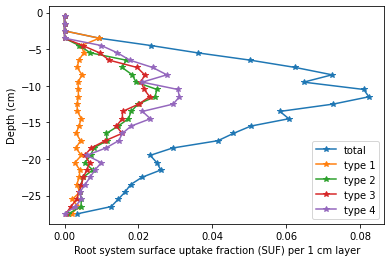

In [20]:
suf = r.get_suf(simtime)[1:]  # returns SUF per segment

ana = pb.SegmentAnalyser(r.rs) # create a segment analyser
ana.addData("SUF", suf)
n = int(np.ceil(-ana.getMinBounds().z)) # cm soil depth
z_ = np.linspace(-0.5, -n + 0.5, n) # layer mid points
d = ana.distribution("SUF", 0., float(-n), int(n), False) 
print("SUF total", np.min(d), np.max(d), np.mean(d), np.sum(d))
plt.plot(d, z_, "-*", label = "total")

max_type = int(np.max(ana.data["subType"]))    
for i in range(1, max_type + 1):
    ana2 = pb.SegmentAnalyser(ana)  # copy
    ana2.filter("subType", i)
    d = ana2.distribution("SUF", 0., float(-n), int(n), False)
    plt.plot(d, z_, "-*", label = "type {:g}".format(i))
    
plt.ylabel("Depth (cm)")
plt.xlabel("Root system surface uptake fraction (SUF) per 1 cm layer")
plt.legend()
plt.show()

/home/rbtlm640/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


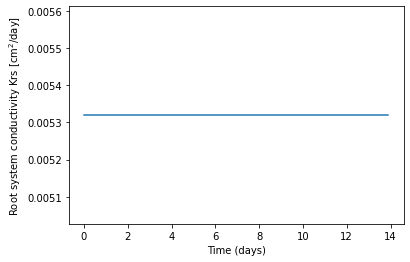

In [21]:
t_ = np.linspace(0, simtime-0.1, 100)
krs_ = []
for t in t_:
    krs, _ = r.get_krs(t)
    krs_.append(krs)
plt.plot(t_, krs_)
plt.xlabel("Time (days)")
plt.ylabel("Root system conductivity Krs [cm$^2$/day]")
plt.show()    

## Take away messages

* Basic idea how to use the class *XylemFluxPython*
* How to set the root axial and radial conductivities in the class *MappedRootSystem*
* How to obtain standard uptake fraction (SUF) and root system conductivity (Krs)

## 2. Soil matric potentials per root segment

Next we couple to a soil represented by soil cells (e.g. numerical FV grid). We couple to a 1D grid using *MappedSegments::setSoilGrid*, see *example6a_mapping.py* for 3D using *MappedSegments::setRectangularGrid* (in *src/MappedOrganism.cpp*).

First we set up the root system as in the example before:

In [23]:
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)

Seed::initialize: RootSystem 
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 3, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
MappedRootSystem::initialize 


and pick parameters

In [24]:
kz = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -1000  # top soil total potential [cm]
p_bot = -100 # bot total potential [cm]
trans = -20  # [cm3/day]

The root segments are coupled to the soil cells (given by *p_s*) with the function *soil_index* that assigns a linear index of a soil cell to each point in space.

In [30]:
" Coupling to soil "
z_ = np.linspace(0,-35,36) # 0, -1, -2, ... -35
mids_ = 0.5*(z_[:-1] + z_[1:]) # 35
p_s = np.linspace(p_top, p_bot, 35)
soil_index = lambda x,y,z : int(np.floor(-z))
rs.setSoilGrid(soil_index)

""" Linear soil index for each segment indices is created by setSoilGrid"""
segs = rs.segments
x = np.zeros(len(segs))
for i, s in enumerate(segs):
    x[i] = rs.seg2cell[i]

The simulation works as before:

In [31]:
""" Set up root conductivities"""
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
rx = r.solve(simtime, trans, 0, p_s, cells = True, wilting_point = -15000) 
fluxes = r.segFluxes(simtime, rx, p_s, cells = True)[1:]  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, p_s, k_soil = [], cells = True), "cm3/day")
print("Root collar", rx[0], "cm")

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)[1:]
fluxes = np.divide(fluxes, surfs)
ana.addData("fluxes", fluxes) 
ana.addData("linear_index", x[1:]) 
# _ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 
# _ = vp.plot_roots(ana, "linear_index", "1") # we can visualize the linear index

Transpiration -20.0 cm3/day
Root collar -4450.148203661988 cm


Finally we can create a sink per 1D soil layer, that sums up the radial fluxes into the roots for each layer:

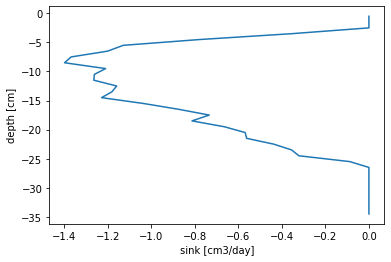

In [32]:
fluxes = r.soilFluxes(simtime, rx, p_s, False, []) # approx = False, k_soil = []
sink = np.zeros((35,))
for k,v in fluxes.items():
    sink[k] = v
plt.plot(sink, mids_)
plt.ylabel("depth [cm]")
_= plt.xlabel("sink [cm3/day]")

Using such a sink, we can easily descrine water depletion from soil (without simulating any soil water movement )

Seed::initialize: RootSystem 
Kr is constant per type, type 0 = 0 1 day-1 
Kx is constant per subtype, subtype 0 = 1 cm3 day-1 
Kr is constant per type, type 0 = 0 1 day-1 
Kx is constant per subtype, subtype 0 = 1 cm3 day-1 
Kr is constant per type, type 0 = 0 1 day-1 
Kx is constant per subtype, subtype 0 = 1 cm3 day-1 
Kr is constant per type, type 0 = 0 1 day-1 
Kx is constant per subtype, subtype 0 = 1 cm3 day-1 
MappedRootSystem::initialize 


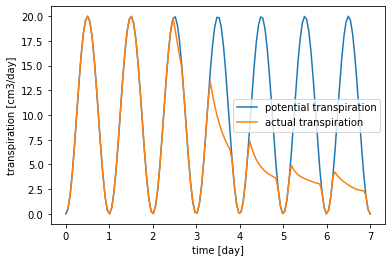

In [34]:
import functional.van_genuchten as vg

sp = vg.Parameters([0.08, 0.43, 0.04, 1.6, 50]) # loam

def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

rs.initialize() # reset previous exmaple
initial_age = 7
rs.simulate(initial_age)

p_top = -2000  # top soil pressure [cm]
p_bot = -1000 # bot soil pressure [cm]
p_s = np.linspace(p_top, p_bot, 35)
cell_volume = 10*10*1 # [cm3]

times = np.linspace(0, 7, 140)
dt_ = np.diff(times)
t = 0 # current simulation time
t_ = [] # actual transpiration

for dt in dt_:
    
    # growth
    rs.simulate(dt)
    t += dt

    # xylem water movement
    trans = -10.*sinusoidal(t)    
    rx = r.solve(initial_age+t, trans, 0, p_s, cells= True, wilting_point = -10000) 
    
    # actual tranpsiration    
    t_.append(r.collar_flux(initial_age+t, rx, p_s, k_soil = [], cells = True))
    
    # deplete soil 
    fluxes = r.soilFluxes(initial_age+t, rx, p_s, False, []) # approx = False, k_soil = []
    for k,v in fluxes.items():
        water_content = vg.water_content(p_s[k]-mids_[k],sp) # total potential to matric potential
        water_content += v*dt / cell_volume 
        p_s[k] = vg.pressure_head(water_content,sp)+mids_[k] #  matric potential to total potential
        
plt.plot(times, 10.*sinusoidal(times), label = "potential transpiration")
plt.plot(times[1:], -np.array(t_), label = "actual transpiration")
plt.xlabel("time [day]")
plt.ylabel("transpiration [cm3/day]")
plt.legend()
plt.show()

To include water movement in soil, we need to solve the Richards equation.

## Take away messages

How to use *MappedRootSystem* to couple the segments to a soil grid